<a href="https://colab.research.google.com/github/glima91/mestrado-redes-neurais/blob/main/Atividade_4_Implementa%C3%A7%C3%A3o_da_fase_backward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementação da fase backward

Para esta atividade deve ser feita uma base para o problema XOR, que deve ter somente 4 exemplos e não vai ter separação de treino e teste.

In [1]:
# Importação de bibliotecas
from sklearn.base import BaseEstimator, ClassifierMixin
import random
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from scipy.special import expit
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from scipy.special import expit

In [2]:
# Funções para plotagem
def plotDataset(X,y):
  plt.xlabel('X1')
  plt.ylabel('X2')
  for k in set(y):
    plt.plot(X[:,0][y == k],X[:,1][y==k],'o',alpha=0.3)

def plothiperplano(X,y,vetor,intercept=0):
  X0min = min(X[:,0])
  X0max = max(X[:,0])
  xs = np.linspace(X0min,X0max,num = 2)
  ys = (-vetor[0]/vetor[1]) * xs-intercept/vetor[1]
  plt.plot(xs,ys)

def define_axes(X):
  margin = 5.0
  min1,max1 = X[:,0].min(),X[:,0].max()
  min2,max2 = X[:,1].min(),X[:,1].max()
  return [min1 - margin,max1 + margin,min2 - margin,max2 + margin]


def plotPredictions(clf,X):
  axes = define_axes(X)
  x0s = np.linspace(axes[0],axes[1],100)
  x1s = np.linspace(axes[2],axes[3],100)
  x0,x1 = np.meshgrid(x0s,x1s)
  X = np.c_[x0.ravel(),x1.ravel()]
  ypred = clf.predict(X).reshape(x0.shape)
  plt.contourf(x0,x1,ypred,cmap=plt.cm.brg,alpha = 0.2)

In [3]:
# Criação do dataset XOR
def criaDatasetXor(n=1000):
  X, y = make_blobs(n_samples=n, centers=[[0,0], [1,0],[1,1],[0,1]], cluster_std=0.0)
  y = np.array(y%2, dtype=int)
  return X, y

In [4]:
# Cria dataset com 4 elementos
Xtr,ytr = criaDatasetXor(n=4)

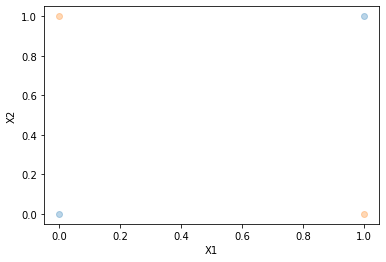

In [5]:
# Plot dos elementos do dataset XOR
plotDataset(Xtr, ytr)

In [6]:
# Implementacao de classes abstratas
class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self,X,y):
    pass

class PseudoInversa(TrainingAlgorithm):
  def getW(self, X,y):
    print(np.linalg.pinv(X) @ y)
    return np.linalg.pinv(X) @ y

In [25]:
# Implementação do MLP com backpropagation
class Backpropagation():
  def __init__(self):
    self.n_hidden = 2
    self.activation = tanh
    self.learning_rate = 0.005
    self.max_iter = 1000

  def foward(self):
    Xb = self.Xb
    self.pH = Xb @ self.wih # o p significa pre ativacao
    self.H = self.activation(self.pH)
    self.Hb = includebias(self.H)
    self.py = self.Hb @ self.who

  def backward(self, y):
    ho_delta = y - self.py
    ho_grad = self.Hb.T @ ho_delta
    # "PULO DO GATO" que é a formula do gradiente simplificada
    tanh_grad = (1 - np.square(tanh(self.pH)))
    ih_delta = (ho_delta @ self.who[1:,:].T) * tanh_grad
    #
    ih_grad = self.Xb.T @ ih_delta 
    self.who += ho_grad * self.learning_rate
    self.wih += ih_grad * self.learning_rate

  def fit(self, X, y):
    self.Xb = includebias(X)
    self.wih = np.random.uniform(-1, 1,  size=(self.Xb.shape[1], self.n_hidden))
    self.who = np.random.uniform(-1, 1, size=(self.n_hidden + 1, y.shape[1]))
    for _ in range(self.max_iter):
      self.foward()
      self.backward(y)

  def predict(self, X, g=None):
      Xb = includebias(X)
      H = self.activation(Xb @ self.wih)
      Hb = includebias(H)
      return Hb @ self.who


def includebias(X):
    bias = np.ones((X.shape[0],1))
    Xb = np.concatenate((bias,X),axis=1)
    return Xb

def tanh(a):
  return expit(a)*2-1

class FixedWeights():
  def __init__(self):
    self.n_hidden = 2
    self.activation = tanh
    self.training = PseudoInversa()
  
  def fit(self, X, y):
    self.wih = np.array([[1.75, 0.95, -0.9], [-1.75, 0.85, -0.9]]).T
    H = self.activation(includebias(X) @ self.wih)
    Hb = includebias(H)
    self.who = self.training.getW(Hb,y)

  def predict(self, X, g=None):
    Xb = includebias(X)
    H = self.activation(Xb @ self.wih)
    Hb = includebias(H)
    return Hb @ self.who


class MLP(BaseEstimator, ClassifierMixin):
  def __init__(self,training_algorithm=FixedWeights()):
    # training algorithm
    self.training_algorithm = training_algorithm
   
  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels) * 2 -1

  def fit(self, X, y):
    yhot = self.encode_labels(y)
    self.training_algorithm.fit(X, yhot)

  def predict(self, X, y=None):
    a = self.training_algorithm.predict(X)
    if len(self.labels) <=2:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

In [26]:
# Treinamento e avaliação do modelo
model = MLP(training_algorithm=Backpropagation())
model.fit(Xtr,ytr)
ypred = model.predict(Xtr,ytr)

print(f"Accuracy:  {sum(ytr == ypred)/len(ytr)}")

Accuracy:  0.5


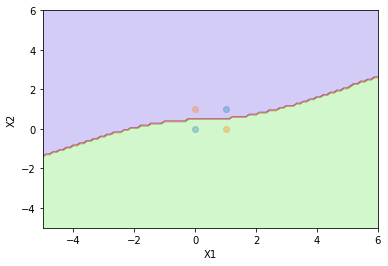

In [27]:
# Análise da separação entre as classes
plotDataset(Xtr,ytr)
plotPredictions(model,Xtr)